# Measuring the impact of preventing Rosie from tagging congresspeople

In February, 2019, [Twitter blocked Rosie claiming she was a spammer](https://medium.com/serenata/a-suspens%C3%A3o-da-rosie-no-twitter-mostra-como-as-regras-para-bots-ainda-precisam-ser-lapidadas-94a0ab8b0003). This notebook tries to understand the impact of such attitude in terms of engagement with Rosie's tweets.

> Before starting, note that this script depends on importing to the environment four variables to allow access to Twitter's API:
>
>  1. `TWITTER_CONSUMER_KEY` 
>  1. `TWITTER_CONSUMER_SECRET`
>  1. `TWITTER_ACCESS_TOKEN_KEY`
>  1. `TWITTER_ACCESS_TOKEN_SECRET`

In [1]:
import os
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import tweepy


pylab.rcParams['figure.figsize'] = (14, 8)
BLOCK_DATE = datetime(2019, 2, 18)  # approx. as Twitter hasn't disclosured it precisely
ROSIE_FIRST_TWEET = 850769069473222656


auth = tweepy.OAuthHandler(
    os.environ.get("TWITTER_CONSUMER_KEY"),
    os.environ.get("TWITTER_CONSUMER_SECRET"),
)
auth.set_access_token(
    os.environ.get("TWITTER_ACCESS_TOKEN_KEY"),
    os.environ.get("TWITTER_ACCESS_TOKEN_SECRET"),
)
api = tweepy.API(auth, wait_on_rate_limit=True)


## Gettings all Rosie tweets

In [2]:
attrs = (
    "id",
    "created_at",
    "favorite_count",
    "retweet_count",
    "text"
)

def get_tweets(last_tweet=None):
    kwargs = {'max_id': last_tweet.id} if last_tweet else {}
    tweets = api.user_timeline("RosieDaSerenata", **kwargs)
    
    tweet = None
    for tweet in tweets:
        if tweet.retweeted:
            continue
        yield {attr: getattr(tweet, attr) for attr in attrs}
    
    if tweet and tweet.id != ROSIE_FIRST_TWEET:
        yield from get_tweets(tweet)

In [3]:
all_tweets = pd.DataFrame(get_tweets())
all_tweets.shape

(1007, 5)

In [4]:
all_tweets.head()

,id,created_at,favorite_count,retweet_count,text
0,1182642041580347392,2019-10-11 13:00:09,26,16,🚨Gasto suspeito de Dep. ROGÉRIO PENINHA MENDON...
1,1182340055190376448,2019-10-10 17:00:10,53,16,🚨Gasto suspeito de Dep. MAJOR OLIMPIO (SP). Vo...
2,1182053161206505472,2019-10-09 22:00:09,35,18,🚨Gasto suspeito de Dep. ALEXANDRE PADILHA (SP)...
3,1181615280331644930,2019-10-08 17:00:10,36,16,🚨Gasto suspeito de Dep. OLIVAL MARQUES (PA). V...
4,1181328380257558528,2019-10-07 22:00:08,47,13,🚨Gasto suspeito de Dep. AFONSO HAMM (RS). Você...


In [5]:
all_tweets.tail()

,id,created_at,favorite_count,retweet_count,text
1002,860524662782033920,2017-05-05 16:00:42,18,11,🚨Gasto suspeito de Dep. @aleluiacosta (BA). Vo...
1003,860162011560370179,2017-05-04 15:59:39,19,9,🚨Gasto suspeito de Dep. @JoseAirtonPT (CE). Vo...
1004,859483983662518272,2017-05-02 19:05:24,32,11,🚨Gasto suspeito de Dep. @dep_edinhobez. Você p...
1005,859137918719467521,2017-05-01 20:10:16,40,13,🚨Gasto suspeito de Dep. @betinhogomes. Você po...
1006,850769069473222656,2017-04-08 17:55:27,93,15,Hello World!


## Isolate suspicions tweets and split them in two groups: before and after the block

First, let's isolate only the tweets related to suspicions and create a new column to sum _favorite_ and _RT_ counts:

In [6]:
tweets = all_tweets[all_tweets.text.str.startswith("🚨Gasto suspeito de")].copy()
tweets["engagement"] = tweets.favorite_count + tweets.retweet_count
tweets.tail()

,id,created_at,favorite_count,retweet_count,text,engagement
1001,860587074981965825,2017-05-05 20:08:42,20,7,🚨Gasto suspeito de Dep. @zeca_dirceu (PR). Voc...,27
1002,860524662782033920,2017-05-05 16:00:42,18,11,🚨Gasto suspeito de Dep. @aleluiacosta (BA). Vo...,29
1003,860162011560370179,2017-05-04 15:59:39,19,9,🚨Gasto suspeito de Dep. @JoseAirtonPT (CE). Vo...,28
1004,859483983662518272,2017-05-02 19:05:24,32,11,🚨Gasto suspeito de Dep. @dep_edinhobez. Você p...,43
1005,859137918719467521,2017-05-01 20:10:16,40,13,🚨Gasto suspeito de Dep. @betinhogomes. Você po...,53


And separate the datasets after and before the block:

In [7]:
before = tweets[tweets.created_at < BLOCK_DATE]
after = tweets[tweets.created_at > BLOCK_DATE]
before.shape, after.shape

((835, 6), (164, 6))

## Engagement as favorites and RTs

/Users/cuducos/.virtualenvs/notebooks/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


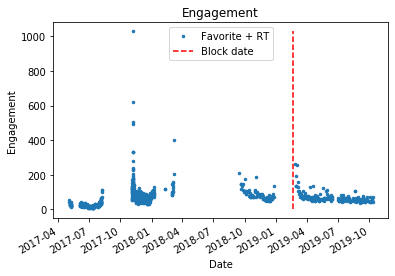

In [8]:
plt.plot_date(tweets["created_at"], tweets["engagement"], markersize=2.5, label="Favorite + RT")
plt.plot((BLOCK_DATE, BLOCK_DATE), (0, tweets['engagement'].max()), label="Block date", color="red", linestyle="dashed")

plt.xlabel('Date')
plt.ylabel('Engagement')

plt.title("Engagement")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

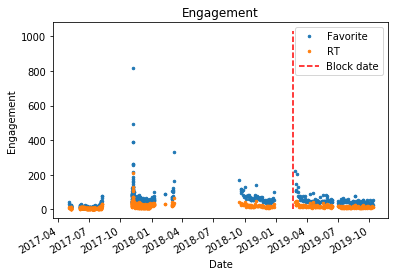

In [9]:
plt.plot_date(tweets["created_at"], tweets["favorite_count"], markersize=2.5, label="Favorite")
plt.plot_date(tweets["created_at"], tweets["retweet_count"], markersize=2.5, label="RT")
plt.plot((BLOCK_DATE, BLOCK_DATE), (0, tweets['engagement'].max()), label="Block date", color="red", linestyle="dashed")

plt.xlabel('Date')
plt.ylabel('Engagement')

plt.title("Engagement")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

## Isolating from 2018 to get the most recent trends

### Linear regression

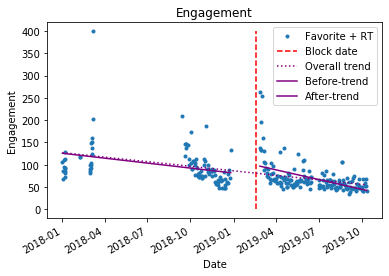

In [10]:
recent = tweets[tweets.created_at.dt.year >= 2018]
trend_before = before[before.created_at.dt.year >= 2018]

plt.plot_date(recent["created_at"], recent["engagement"], markersize=3, label="Favorite + RT")
plt.plot((BLOCK_DATE, BLOCK_DATE), (0, recent['engagement'].max()), label="Block date", color="red", linestyle="--")

# overall trend
x = mdates.date2num(recent["created_at"])
fit = np.polyfit(x, recent["engagement"], 1)
xx = np.linspace(x.min(), x.max(), 100)
dd = mdates.num2date(xx)
plt.plot(dd, np.poly1d(fit)(xx), color="purple", linestyle=":", label="Overall trend")

# before trend
x = mdates.date2num(trend_before["created_at"])
fit = np.polyfit(x, trend_before["engagement"], 1)
xx = np.linspace(x.min(), x.max(), 100)
dd = mdates.num2date(xx)
plt.plot(dd, np.poly1d(fit)(xx), color="purple", label="Before-trend")

# after trend
x = mdates.date2num(after["created_at"])
fit = np.polyfit(x, after["engagement"], 1)
xx = np.linspace(x.min(), x.max(), 100)
dd = mdates.num2date(xx)
plt.plot(dd, np.poly1d(fit)(xx), color="purple", label="After-trend")

plt.xlabel('Date')
plt.ylabel('Engagement')

plt.title("Engagement")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

Using a linear regression, numbers suggest that by mid-October **the impact of Twitter's block has been negative** in terms of engagement with Rosie's tweets – as the slope is more skwed down after the block.

### Quadratic regression

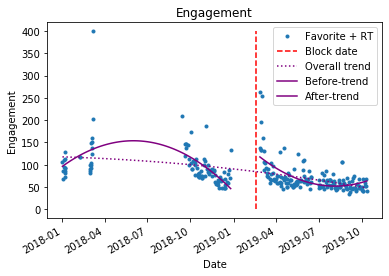

In [11]:
recent = tweets[tweets.created_at.dt.year >= 2018]
trend_before = before[before.created_at.dt.year >= 2018]

plt.plot_date(recent["created_at"], recent["engagement"], markersize=3, label="Favorite + RT")
plt.plot((BLOCK_DATE, BLOCK_DATE), (0, recent['engagement'].max()), label="Block date", color="red", linestyle="--")

# overall trend
x = mdates.date2num(recent["created_at"])
fit = np.polyfit(x, recent["engagement"], 2)
xx = np.linspace(x.min(), x.max(), 100)
dd = mdates.num2date(xx)
plt.plot(dd, np.poly1d(fit)(xx), color="purple", linestyle=":", label="Overall trend")

# before trend
x = mdates.date2num(trend_before["created_at"])
fit = np.polyfit(x, trend_before["engagement"], 2)
xx = np.linspace(x.min(), x.max(), 100)
dd = mdates.num2date(xx)
plt.plot(dd, np.poly1d(fit)(xx), color="purple", label="Before-trend")

# after trend
x = mdates.date2num(after["created_at"])
fit = np.polyfit(x, after["engagement"], 2)
xx = np.linspace(x.min(), x.max(), 100)
dd = mdates.num2date(xx)
plt.plot(dd, np.poly1d(fit)(xx), color="purple", label="After-trend")

plt.xlabel('Date')
plt.ylabel('Engagement')

plt.title("Engagement")
plt.gcf().autofmt_xdate()
plt.legend()
plt.show()

Using a quadratic regression, numbers suggest that by mid-October **the impact of Twitter's block has been positive** in terms of engagement with Rosie's tweets – as the parabole opens upward instead of downward.